# Instrument Recognition Based on Deep CNN

## Import Librarys

In [6]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

## Audio Preprocessing

In [7]:
import os
import numpy as np
import librosa

# Function to preprocess audio and compute mel-spectrogram
def preprocess_audio(file_path,
                     target_sr=22050,
                     n_fft=1024,
                     hop_length=512,
                     n_mels=128,
                     max_length=3.0):
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=target_sr, mono=True)

        # Normalize the audio signal
        if np.max(np.abs(y)) > 0:
            y = y / np.max(np.abs(y))

        # Ensure consistency in audio length
        max_length_samples = int(target_sr * max_length)
        if len(y) > max_length_samples:
            y = y[:max_length_samples]
        else:
            pad_width = max_length_samples - len(y)
            y = np.pad(y, (0, pad_width), mode='constant')

        # Compute Mel-Spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                         sr=target_sr,
                                                         n_fft=n_fft,
                                                         hop_length=hop_length,
                                                         n_mels=n_mels,
                                                         fmax=target_sr / 2)

        # Apply natural logarithm
        log_mel_spectrogram = np.log(mel_spectrogram + 1e-9)  # Add epsilon to avoid log(0)

        return log_mel_spectrogram
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Function to save mel-spectrogram to disk
def save_mel_spectrogram(mel_spec, save_path):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    np.save(save_path, mel_spec)

def process_dataset(data_dirs, save_dir, max_length=3.0):
    for data_dir in data_dirs:
        for root, _, files in os.walk(data_dir):
            for file in files:
                if file.endswith('.wav'):
                    file_path = os.path.join(root, file)
                    relative_path = os.path.relpath(file_path, data_dir)
                    save_path = os.path.join(save_dir, relative_path) + '.npy'

                    # Skip if the file already exists
                    if os.path.exists(save_path):
                        continue

                    mel_spec = preprocess_audio(file_path, max_length=max_length)
                    if mel_spec is not None:
                        save_mel_spectrogram(mel_spec, save_path)
                        print(f"Processed and saved: {save_path}")
                    else:
                        print(f"Failed to process {file_path}")

if __name__ == '__main__':
    # Directories
    train_dir = "./../../../IRMAS/IRMAS-TrainingData"
    test_dir_part1 = "./../../../IRMAS/IRMAS-TestingData-Part1/Part1"
    test_dir_part2 = "./../../../IRMAS/IRMAS-TestingData-Part2/IRTestingData-Part2"

    # List of data directories to process
    data_dirs = [train_dir, test_dir_part1, test_dir_part2]

    # Directory to save the precomputed mel-spectrograms
    save_dir = './preprocessed_data'

    process_dataset(data_dirs, save_dir)

### Visualization of mel spectrogram

Log-Mel Spectrogram shape: (128, 130)


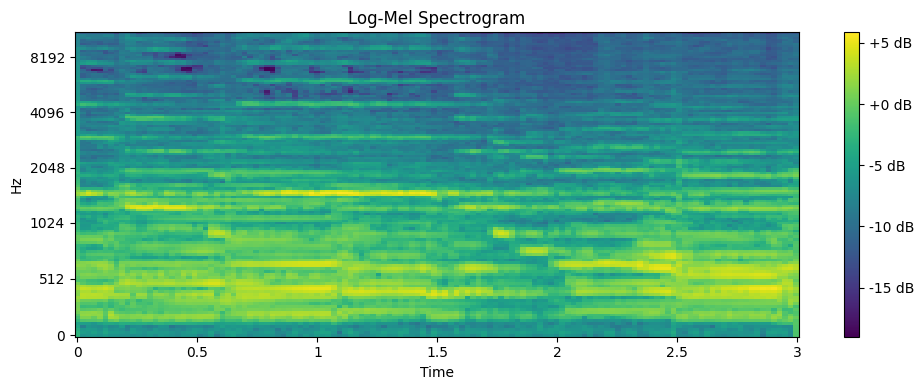

In [8]:
# Example usage:

# Path to a sample audio file
sample_file = './../../../IRMAS/IRMAS-TrainingData/flu/008__[flu][nod][cla]0393__1.wav'  # Replace with your actual file path

# Preprocess the audio
log_mel_spec = preprocess_audio(sample_file)

print(f"Log-Mel Spectrogram shape: {log_mel_spec.shape}")

# Visualize the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel_spec,
                         sr=22050,
                         hop_length=512,
                         x_axis='time',
                         y_axis='mel',
                         cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram')
plt.tight_layout()
plt.show()

## Training and Testing Data Process
### Loading Dataset

In [9]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import random

# Set seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    # For deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Function to clean and process label strings
def clean_labels(label_text):
    """
    Cleans and splits raw label text from .txt files.
    Handles artifacts like tabs, newlines, and extra spaces.
    """
    labels = [label.strip() for label in label_text.split() if label.strip()]
    # Remove any numeric-only labels or unexpected characters
    labels = [label for label in labels if not label.isdigit()]
    return labels

# Function to clean and process label strings
def clean_labels(label_text):
    """
    Cleans and splits raw label text from .txt files.
    Handles artifacts like tabs, newlines, and extra spaces.
    """
    labels = [label.strip() for label in label_text.split() if label.strip()]
    # Remove any numeric-only labels or unexpected characters
    labels = [label for label in labels if not label.isdigit()]
    return labels

# Preprocess Audio Function
def preprocess_audio(file_path,
                     target_sr=22050,
                     n_fft=1024,
                     hop_length=512,
                     n_mels=128,
                     max_length=3.0):
    """
    Preprocess an audio file for instrument recognition.

    Returns:
        np.ndarray: Log-mel spectrogram of shape (n_mels, time_steps)
    """
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=target_sr, mono=True)

        # Normalize the audio signal
        if np.max(np.abs(y)) > 0:
            y = y / np.max(np.abs(y))

        # Ensure consistency in audio length
        max_length_samples = int(target_sr * max_length)
        if len(y) > max_length_samples:
            y = y[:max_length_samples]
        else:
            pad_width = max_length_samples - len(y)
            y = np.pad(y, (0, pad_width), mode='constant')

        # Compute Mel-Spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                         sr=target_sr,
                                                         n_fft=n_fft,
                                                         hop_length=hop_length,
                                                         n_mels=n_mels,
                                                         fmax=target_sr / 2)

        # Apply natural logarithm
        log_mel_spectrogram = np.log(mel_spectrogram + 1e-9)  # Add epsilon to avoid log(0)

        return log_mel_spectrogram
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

class IRMASDataset(Dataset):
    def __init__(self, file_paths, labels, label_encoder, mel_specs_dir,
                 max_length=3.0,
                 segment_length=1.0,
                 transform=None):
        """
        Custom PyTorch Dataset for IRMAS data with precomputed mel-spectrograms.

        Args:
            file_paths (list): List of audio file paths.
            labels (list): List of labels (list of instruments) for each file.
            label_encoder (LabelEncoder): Fitted LabelEncoder.
            mel_specs_dir (str): Directory where precomputed mel-spectrograms are stored.
            max_length (float): Maximum audio length in seconds.
            segment_length (float): Length of each segment in seconds.
            transform (callable): Transform to apply to mel-spectrogram.
        """
        self.file_paths = file_paths
        self.labels = labels  # List of lists of instrument labels
        self.label_encoder = label_encoder
        self.mel_specs_dir = mel_specs_dir
        self.max_length = max_length
        self.segment_length = segment_length
        self.transform = transform

        self.num_segments = int(self.max_length / self.segment_length)

        # Create a mapping from audio file paths to mel-spectrogram paths
        self.mel_spec_paths = [self.get_mel_spec_path(fp) for fp in self.file_paths]

    def get_mel_spec_path(self, audio_path):
        # Get the relative path from the data directory
        relative_path = os.path.relpath(audio_path, start=os.path.commonpath(self.file_paths))
        # Construct the path to the mel-spectrogram
        mel_spec_path = os.path.join(self.mel_specs_dir, relative_path) + '.npy'
        return mel_spec_path

    def __len__(self):
        return len(self.file_paths) * self.num_segments

    def __getitem__(self, idx):
        # Determine which file and segment this index corresponds to
        file_idx = idx // self.num_segments
        segment_idx = idx % self.num_segments

        mel_spec_path = self.mel_spec_paths[file_idx]
        labels = self.labels[file_idx]  # List of instrument labels for the file

        # Load precomputed mel-spectrogram
        if os.path.exists(mel_spec_path):
            mel_spec = np.load(mel_spec_path)
        else:
            # Handle missing mel-spectrogram files
            print(f"Mel-spectrogram not found at {mel_spec_path}. Using zeros.")
            mel_spec = np.zeros((128, int(self.max_length * 22050 / 512) + 1))

        mel_spec = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0)  # Shape: [1, 128, time_frames]

        # Calculate segment parameters
        total_frames = mel_spec.shape[2]
        frames_per_segment = total_frames // self.num_segments

        start_frame = segment_idx * frames_per_segment
        end_frame = start_frame + frames_per_segment
        segment = mel_spec[:, :, start_frame:end_frame]  # Shape: [1, 128, frames_per_segment]

        # Handle any leftover frames by padding
        if segment.shape[2] < frames_per_segment:
            pad_amount = frames_per_segment - segment.shape[2]
            segment = F.pad(segment, (0, pad_amount), "constant", 0)

        # Apply any transformations
        if self.transform:
            segment = self.transform(segment)

        # Convert labels to multi-hot encoding
        label_indices = self.label_encoder.transform(labels)
        target = torch.zeros(len(self.label_encoder.classes_), dtype=torch.float32)
        target[label_indices] = 1.0

        return segment, target

def get_metadata(train_dir, test_dir_part1, test_dir_part2):
    """
    Collects file paths and labels from training and testing directories.

    Returns:
        train_file_paths (list): List of training audio file paths.
        train_labels (list): List of label lists for training data.
        test_file_paths (list): List of testing audio file paths.
        test_labels (list): List of label lists for testing data.
    """
    train_file_paths = []
    train_labels = []
    test_file_paths = []
    test_labels = []

    # Process Training Data
    for subdir in os.listdir(train_dir):
        subfolder_path = os.path.join(train_dir, subdir)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(subfolder_path, file)
                    train_file_paths.append(file_path)
                    train_labels.append([subdir])  # Subfolder name as label list

    # Process Testing Data Part 1 and Part 2
    for test_dir in [test_dir_part1, test_dir_part2]:
        if not os.path.exists(test_dir):
            continue
        for file in os.listdir(test_dir):
            if file.endswith(".wav"):
                file_path = os.path.join(test_dir, file)
                txt_file_path = os.path.splitext(file_path)[0] + ".txt"
                test_file_paths.append(file_path)

                # Read the labels from the .txt file
                if os.path.exists(txt_file_path):
                    with open(txt_file_path, "r") as txt_file:
                        raw_labels = txt_file.read()
                        labels = clean_labels(raw_labels)
                        test_labels.append(labels)
                else:
                    # Handle missing label files
                    test_labels.append(["unknown"])  # Assign default label

    return train_file_paths, train_labels, test_file_paths, test_labels

# Directories
train_dir = "./../../../IRMAS/IRMAS-TrainingData"
test_dir_part1 = "./../../../IRMAS/IRMAS-TestingData-Part1/Part1"
test_dir_part2 = "./../../../IRMAS/IRMAS-TestingData-Part2/IRTestingData-Part2"

# Extract metadata
train_file_paths, train_labels, test_file_paths, test_labels = get_metadata(train_dir, test_dir_part1, test_dir_part2)

# Combine all labels from training and testing data
all_labels = train_labels + test_labels
all_label_list = [label for labels in all_labels for label in labels]
# Remove duplicates
all_label_list = list(set(all_label_list))
# Remove 'unknown' label if present
if 'unknown' in all_label_list:
    all_label_list.remove('unknown')

# Fit the LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(all_label_list)

# Split training data into training and validation sets
train_files, val_files, train_labels_split, val_labels_split = train_test_split(
    train_file_paths,
    train_labels,
    test_size=0.15,
    random_state=42,
    shuffle=True,
    stratify=train_labels
)

print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")

Training samples: 5699
Validation samples: 1006


### Building Dataloader for Network

In [10]:
# Directory where precomputed mel-spectrograms are stored
mel_specs_dir = './preprocessed_data'

# Create Dataset instances
train_dataset = IRMASDataset(
    file_paths=train_files,
    labels=train_labels_split,
    label_encoder=label_encoder,
    mel_specs_dir=mel_specs_dir,
    max_length=3.0,
    segment_length=1.0
)

val_dataset = IRMASDataset(
    file_paths=val_files,
    labels=val_labels_split,
    label_encoder=label_encoder,
    mel_specs_dir=mel_specs_dir,
    max_length=3.0,
    segment_length=1.0
)

# Define batch size and number of workers
batch_size = 128
num_workers = 8  # Adjust as per your system capabilities

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)



### Visualization of Dataset

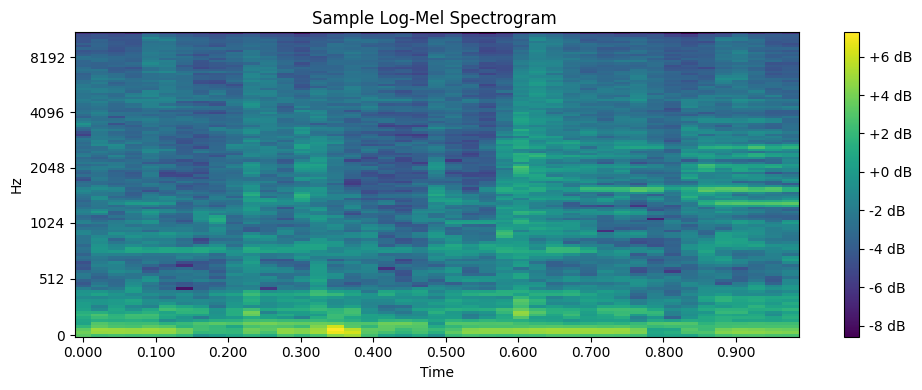

In [11]:
import librosa.display
import matplotlib.pyplot as plt


# Get a sample from the training dataset
sample_mel_spec, sample_label = train_dataset[0]




# Convert tensor to numpy for visualization
sample_mel_spec_np = sample_mel_spec.squeeze(0).numpy()

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(sample_mel_spec_np,
                         sr=22050,
                         hop_length=512,
                         x_axis='time',
                         y_axis='mel',
                         cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Sample Log-Mel Spectrogram ')
plt.tight_layout()
plt.show()

## Deep CNN Model

In [12]:
class InstrumentCNN(nn.Module):
    def __init__(self, num_classes):
        super(InstrumentCNN, self).__init__()

        # Convolutional Block 1
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.dropout1 = nn.Dropout(0.25)

        # Convolutional Block 2
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.dropout2 = nn.Dropout(0.25)

        # Convolutional Block 3
        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.dropout3 = nn.Dropout(0.25)

        # Convolutional Block 4
        self.conv4_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        # Global Max Pooling
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))

        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 1 * 1, 1024)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)

        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        # Convolutional Block 1
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Convolutional Block 2
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Convolutional Block 3
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Convolutional Block 4
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))

        # Global Max Pooling
        x = self.global_pool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)

        return x  # Do not apply sigmoid here

    def _initialize_weights(self):
        # Initialize weights using Xavier uniform initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

## Training

In [15]:
# Instantiate the model
num_classes = len(label_encoder.classes_)
model = InstrumentCNN(num_classes=num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current Training Session is Running on: ", device)
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Combines sigmoid activation and binary cross-entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 50  # You can adjust this
early_stopping_patience = 10
best_val_loss = np.inf
epochs_no_improve = 0

# Lists to store losses and metrics
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
        inputs = inputs.to(device)  # Shape: [batch_size, 1, 128, frames_per_segment]
        targets = targets.to(device)  # Shape: [batch_size, num_classes]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item() * inputs.size(0)

        # Collect predictions and targets for metric computation
        preds = torch.sigmoid(outputs).detach().cpu().numpy()  # Apply sigmoid for probabilities
        targets_np = targets.detach().cpu().numpy()
        all_preds.append(preds)
        all_targets.append(targets_np)

    # Calculate average loss over the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Compute F1 Score
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    # Binarize predictions with a threshold (e.g., 0.5)
    all_preds_binary = (all_preds >= 0.5).astype(int)
    train_f1 = f1_score(all_targets, all_preds_binary, average='micro', zero_division=0)
    train_f1_scores.append(train_f1)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_all_preds = []
    val_all_targets = []

    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)

            # Accumulate loss
            val_running_loss += loss.item() * inputs.size(0)

            # Collect predictions and targets
            preds = torch.sigmoid(outputs).cpu().numpy()
            targets_np = targets.cpu().numpy()
            val_all_preds.append(preds)
            val_all_targets.append(targets_np)

    # Calculate average validation loss
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(val_epoch_loss)

    # Compute validation F1 Score
    val_all_preds = np.vstack(val_all_preds)
    val_all_targets = np.vstack(val_all_targets)
    val_all_preds_binary = (val_all_preds >= 0.5).astype(int)
    val_f1 = f1_score(val_all_targets, val_all_preds_binary, average='micro', zero_division=0)
    val_f1_scores.append(val_f1)

    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {epoch_loss:.4f}, Train F1: {train_f1:.4f} - "
          f"Val Loss: {val_epoch_loss:.4f}, Val F1: {val_f1:.4f}")

    # Early Stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
        print("Validation loss decreased. Model saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping triggered.")
            break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Save the final model
torch.save(model.state_dict(), 'final_model.pth')
print("Training completed. Model saved as 'final_model.pth'.")



Current Training Session is Running on:  cuda


Epoch 1/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.84it/s]


Epoch [1/50] - Train Loss: 0.3121, Train F1: 0.0083 - Val Loss: 0.3247, Val F1: 0.0000
Validation loss decreased. Model saved.


Epoch 2/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.77it/s]


Epoch [2/50] - Train Loss: 0.2897, Train F1: 0.0023 - Val Loss: 0.2903, Val F1: 0.0000
Validation loss decreased. Model saved.


Epoch 3/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.77it/s]


Epoch [3/50] - Train Loss: 0.2750, Train F1: 0.0411 - Val Loss: 0.2911, Val F1: 0.0593


Epoch 4/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.75it/s]


Epoch [4/50] - Train Loss: 0.2605, Train F1: 0.1357 - Val Loss: 0.2543, Val F1: 0.0972
Validation loss decreased. Model saved.


Epoch 5/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.62it/s]


Epoch [5/50] - Train Loss: 0.2477, Train F1: 0.2129 - Val Loss: 0.2466, Val F1: 0.1552
Validation loss decreased. Model saved.


Epoch 6/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.63it/s]


Epoch [6/50] - Train Loss: 0.2351, Train F1: 0.2635 - Val Loss: 0.2329, Val F1: 0.1447
Validation loss decreased. Model saved.


Epoch 7/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.66it/s]


Epoch [7/50] - Train Loss: 0.2237, Train F1: 0.3179 - Val Loss: 0.2249, Val F1: 0.2544
Validation loss decreased. Model saved.


Epoch 8/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.81it/s]


Epoch [8/50] - Train Loss: 0.2152, Train F1: 0.3551 - Val Loss: 0.2069, Val F1: 0.3396
Validation loss decreased. Model saved.


Epoch 9/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.68it/s]


Epoch [9/50] - Train Loss: 0.2064, Train F1: 0.3920 - Val Loss: 0.2011, Val F1: 0.3701
Validation loss decreased. Model saved.


Epoch 10/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.43it/s]


Epoch [10/50] - Train Loss: 0.1971, Train F1: 0.4305 - Val Loss: 0.1982, Val F1: 0.4340
Validation loss decreased. Model saved.


Epoch 11/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.75it/s]


Epoch [11/50] - Train Loss: 0.1906, Train F1: 0.4630 - Val Loss: 0.1915, Val F1: 0.4657
Validation loss decreased. Model saved.


Epoch 12/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.87it/s]


Epoch [12/50] - Train Loss: 0.1847, Train F1: 0.4885 - Val Loss: 0.1819, Val F1: 0.4875
Validation loss decreased. Model saved.


Epoch 13/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.82it/s]


Epoch [13/50] - Train Loss: 0.1781, Train F1: 0.5159 - Val Loss: 0.1847, Val F1: 0.4953


Epoch 14/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.83it/s]


Epoch [14/50] - Train Loss: 0.1707, Train F1: 0.5424 - Val Loss: 0.1819, Val F1: 0.5142


Epoch 15/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.78it/s]


Epoch [15/50] - Train Loss: 0.1673, Train F1: 0.5595 - Val Loss: 0.1812, Val F1: 0.5082
Validation loss decreased. Model saved.


Epoch 16/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.85it/s]


Epoch [16/50] - Train Loss: 0.1616, Train F1: 0.5814 - Val Loss: 0.1789, Val F1: 0.5429
Validation loss decreased. Model saved.


Epoch 17/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.85it/s]


Epoch [17/50] - Train Loss: 0.1567, Train F1: 0.5984 - Val Loss: 0.1704, Val F1: 0.5638
Validation loss decreased. Model saved.


Epoch 18/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.87it/s]


Epoch [18/50] - Train Loss: 0.1546, Train F1: 0.6070 - Val Loss: 0.1703, Val F1: 0.5909
Validation loss decreased. Model saved.


Epoch 19/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.81it/s]


Epoch [19/50] - Train Loss: 0.1485, Train F1: 0.6315 - Val Loss: 0.1660, Val F1: 0.5892
Validation loss decreased. Model saved.


Epoch 20/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.85it/s]


Epoch [20/50] - Train Loss: 0.1468, Train F1: 0.6377 - Val Loss: 0.1781, Val F1: 0.5577


Epoch 21/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.89it/s]


Epoch [21/50] - Train Loss: 0.1440, Train F1: 0.6455 - Val Loss: 0.1644, Val F1: 0.5871
Validation loss decreased. Model saved.


Epoch 22/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.37it/s]


Epoch [22/50] - Train Loss: 0.1373, Train F1: 0.6650 - Val Loss: 0.1658, Val F1: 0.5993


Epoch 23/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.70it/s]


Epoch [23/50] - Train Loss: 0.1337, Train F1: 0.6763 - Val Loss: 0.1688, Val F1: 0.6099


Epoch 24/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.66it/s]


Epoch [24/50] - Train Loss: 0.1333, Train F1: 0.6763 - Val Loss: 0.1601, Val F1: 0.6080
Validation loss decreased. Model saved.


Epoch 25/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.81it/s]


Epoch [25/50] - Train Loss: 0.1279, Train F1: 0.6971 - Val Loss: 0.1691, Val F1: 0.6029


Epoch 26/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.80it/s]


Epoch [26/50] - Train Loss: 0.1252, Train F1: 0.7026 - Val Loss: 0.1575, Val F1: 0.6303
Validation loss decreased. Model saved.


Epoch 27/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.45it/s]


Epoch [27/50] - Train Loss: 0.1235, Train F1: 0.7070 - Val Loss: 0.1594, Val F1: 0.6331


Epoch 28/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.65it/s]


Epoch [28/50] - Train Loss: 0.1215, Train F1: 0.7142 - Val Loss: 0.1582, Val F1: 0.6251


Epoch 29/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.82it/s]


Epoch [29/50] - Train Loss: 0.1206, Train F1: 0.7167 - Val Loss: 0.1644, Val F1: 0.6244


Epoch 30/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.70it/s]


Epoch [30/50] - Train Loss: 0.1162, Train F1: 0.7286 - Val Loss: 0.1611, Val F1: 0.6341


Epoch 31/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.63it/s]


Epoch [31/50] - Train Loss: 0.1131, Train F1: 0.7355 - Val Loss: 0.1642, Val F1: 0.6151


Epoch 32/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.53it/s]


Epoch [32/50] - Train Loss: 0.1117, Train F1: 0.7391 - Val Loss: 0.1624, Val F1: 0.6444


Epoch 33/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.63it/s]


Epoch [33/50] - Train Loss: 0.1087, Train F1: 0.7486 - Val Loss: 0.1773, Val F1: 0.6451


Epoch 34/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.55it/s]


Epoch [34/50] - Train Loss: 0.1076, Train F1: 0.7525 - Val Loss: 0.1674, Val F1: 0.6357


Epoch 35/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.65it/s]


Epoch [35/50] - Train Loss: 0.1034, Train F1: 0.7580 - Val Loss: 0.1680, Val F1: 0.6593


Epoch 36/50 [Validation]: 100%|██████████| 24/24 [00:03<00:00,  6.80it/s]

Epoch [36/50] - Train Loss: 0.1053, Train F1: 0.7564 - Val Loss: 0.1612, Val F1: 0.6449
Early stopping triggered.
Training completed. Model saved as 'final_model.pth'.


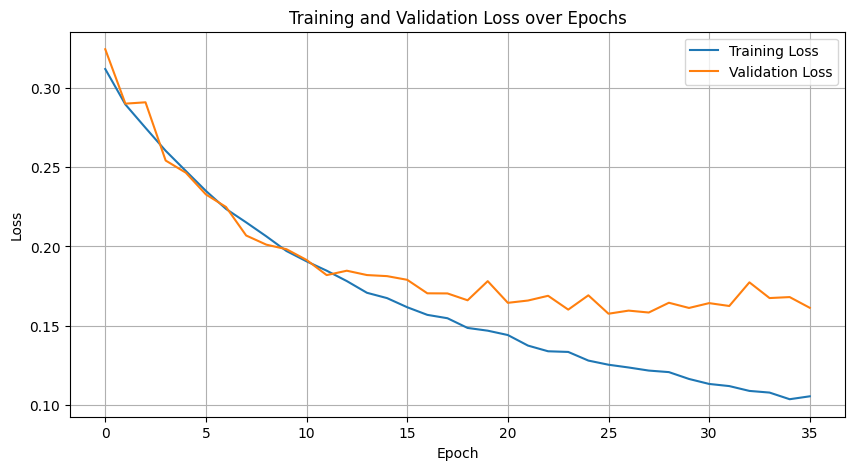

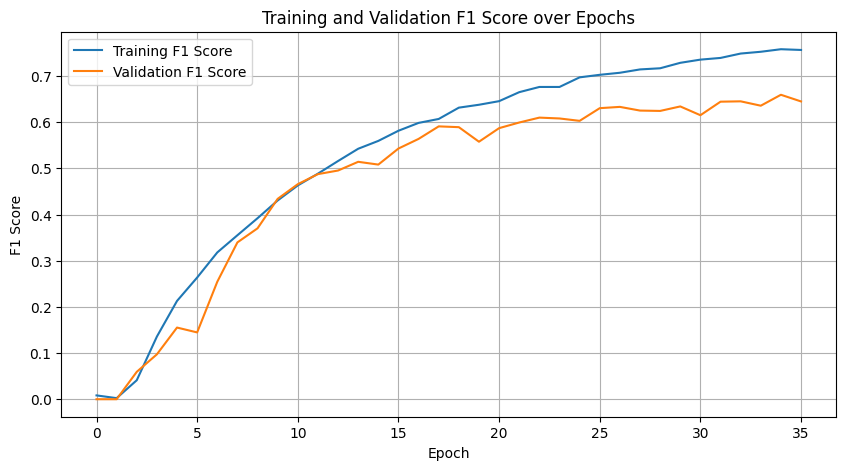

In [16]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation F1 Score
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label='Training F1 Score')
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.title('Training and Validation F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

## Model Evalation

### Testset

In [17]:
import torch
from torch.utils.data import Dataset
import numpy as np
import librosa
import os

class IRMASTestDataset(Dataset):
    def __init__(self, file_paths, labels, label_encoder,
                 target_sr=22050,
                 n_fft=1024,
                 hop_length=512,
                 n_mels=128,
                 window_size=3.0,
                 hop_size=None,
                 transform=None):
        """
        Dataset for test audio files with variable lengths and overlapping windows.

        Args:
            file_paths (list): List of test audio file paths.
            labels (list): List of labels (list of instruments) for each file.
            label_encoder (LabelEncoder): Fitted LabelEncoder.
            window_size (float): Window size in seconds (same as training window).
            hop_size (float): Hop size in seconds (half of window size if None).
            transform (callable): Optional transform to be applied on a sample.
        """
        self.file_paths = file_paths
        self.labels = labels
        self.label_encoder = label_encoder
        self.target_sr = target_sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.window_size = window_size
        self.hop_size = hop_size if hop_size is not None else window_size / 2
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        labels = self.labels[idx]

        # Load the audio file
        y, sr = librosa.load(file_path, sr=self.target_sr, mono=True)

        # Normalize the audio signal
        if np.max(np.abs(y)) > 0:
            y = y / np.max(np.abs(y))

        # Calculate the number of samples per window and hop
        window_length_samples = int(self.window_size * self.target_sr)
        hop_length_samples = int(self.hop_size * self.target_sr)

        # Compute the number of windows
        total_length = len(y)
        num_windows = int(np.ceil((total_length - window_length_samples) / hop_length_samples)) + 1

        # Segment the audio into overlapping windows
        segments = []
        for i in range(num_windows):
            start = i * hop_length_samples
            end = start + window_length_samples
            segment = y[start:end]

            # Pad segment if necessary
            if len(segment) < window_length_samples:
                pad_width = window_length_samples - len(segment)
                segment = np.pad(segment, (0, pad_width), mode='constant')

            # Compute mel-spectrogram
            mel_spec = librosa.feature.melspectrogram(
                y=segment,
                sr=self.target_sr,
                n_fft=self.n_fft,
                hop_length=self.hop_length,
                n_mels=self.n_mels,
                fmax=self.target_sr / 2
            )
            # Apply logarithm
            mel_spec = np.log(mel_spec + 1e-9)
            segments.append(mel_spec)

        # Convert list of segments to a tensor
        segments = np.array(segments)  # Shape: [num_windows, n_mels, time_frames]
        segments = torch.tensor(segments, dtype=torch.float32)

        # Add channel dimension
        segments = segments.unsqueeze(1)  # Shape: [num_windows, 1, n_mels, time_frames]

        # Apply transformations if any
        if self.transform:
            segments = self.transform(segments)

        # Convert labels to multi-hot encoding
        label_indices = self.label_encoder.transform(labels)
        target = torch.zeros(len(self.label_encoder.classes_), dtype=torch.float32)
        target[label_indices] = 1.0

        return segments, target, file_path  # Return file_path for identification

# Instantiate the test dataset
test_dataset = IRMASTestDataset(
    file_paths=test_file_paths,
    labels=test_labels,
    label_encoder=label_encoder,
    target_sr=22050,
    n_fft=1024,
    hop_length=512,
    n_mels=128,
    window_size=3.0,  # Same as training window size
    hop_size=1.5,     # Half of the window size
    transform=None
)

# Create DataLoader for the test set
test_loader = DataLoader(
    test_dataset,
    batch_size=1,  # Batch size of 1 since each item may have different number of segments
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

### Model Prediction


Testing: 100%|██████████| 2108/2108 [04:58<00:00,  7.06it/s]


Threshold: 0.20, F1 Score: 0.5210
Threshold: 0.25, F1 Score: 0.5404
Threshold: 0.30, F1 Score: 0.5561
Threshold: 0.35, F1 Score: 0.5666
Threshold: 0.40, F1 Score: 0.5746
Threshold: 0.45, F1 Score: 0.5787
Threshold: 0.50, F1 Score: 0.5807
Threshold: 0.55, F1 Score: 0.5804
Threshold: 0.60, F1 Score: 0.5837
Threshold: 0.65, F1 Score: 0.5813
Threshold: 0.70, F1 Score: 0.5807
Threshold: 0.75, F1 Score: 0.5813
Threshold: 0.80, F1 Score: 0.5816

Best Threshold: 0.60, Best F1 Score: 0.5837
Class: cel
  Precision: 0.3500
  Recall:    0.2308
  F1 Score:  0.2781
  Confusion Matrix:
[[1978   39]
 [  70   21]]



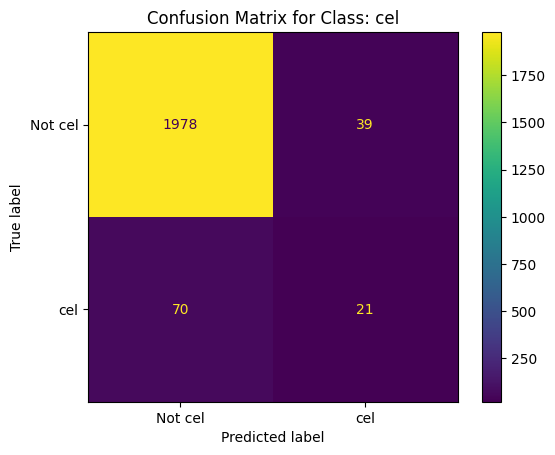

Class: cla
  Precision: 0.0889
  Recall:    0.1176
  F1 Score:  0.1013
  Confusion Matrix:
[[2033   41]
 [  30    4]]



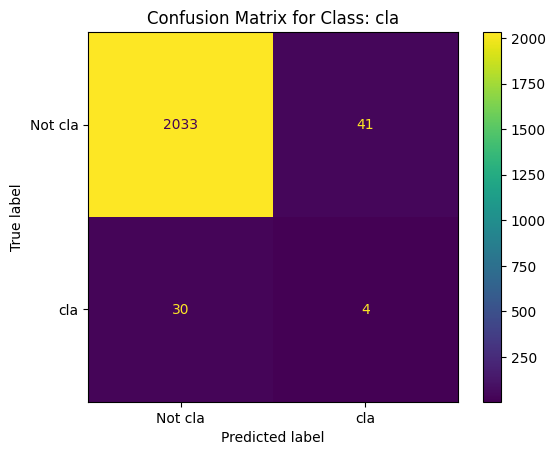

Class: flu
  Precision: 0.6306
  Recall:    0.6087
  F1 Score:  0.6195
  Confusion Matrix:
[[1952   41]
 [  45   70]]



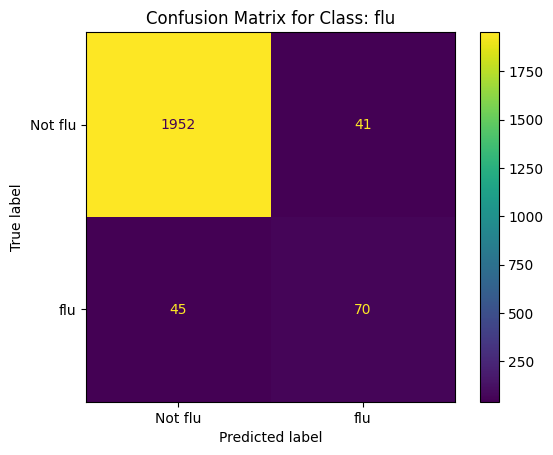

Class: gac
  Precision: 0.6280
  Recall:    0.4067
  F1 Score:  0.4937
  Confusion Matrix:
[[1629   93]
 [ 229  157]]



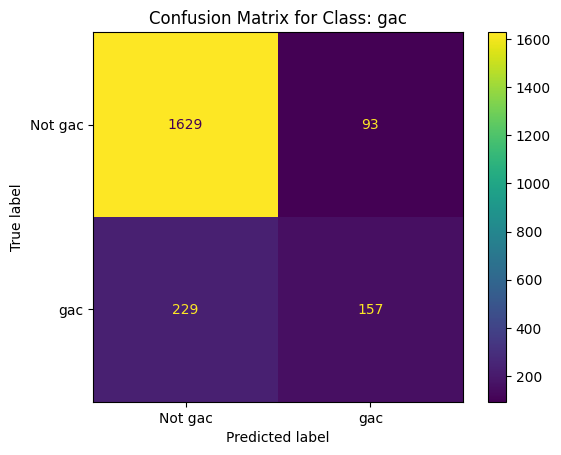

Class: gel
  Precision: 0.6726
  Recall:    0.4339
  F1 Score:  0.5275
  Confusion Matrix:
[[1265  147]
 [ 394  302]]



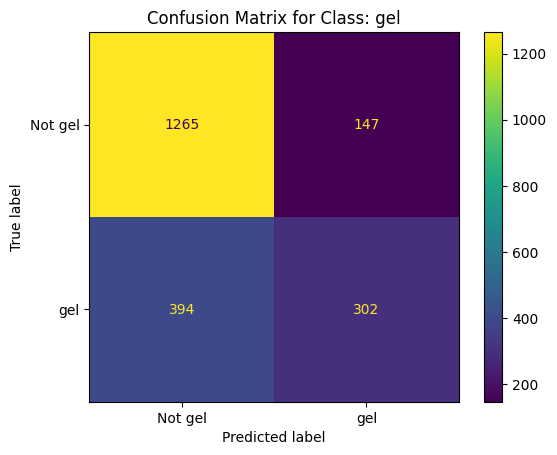

Class: org
  Precision: 0.4086
  Recall:    0.4023
  F1 Score:  0.4054
  Confusion Matrix:
[[1695  152]
 [ 156  105]]



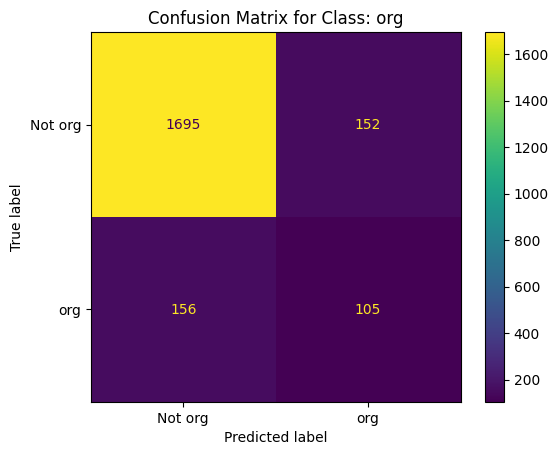

Class: pia
  Precision: 0.8565
  Recall:    0.2736
  F1 Score:  0.4147
  Confusion Matrix:
[[1332   34]
 [ 539  203]]



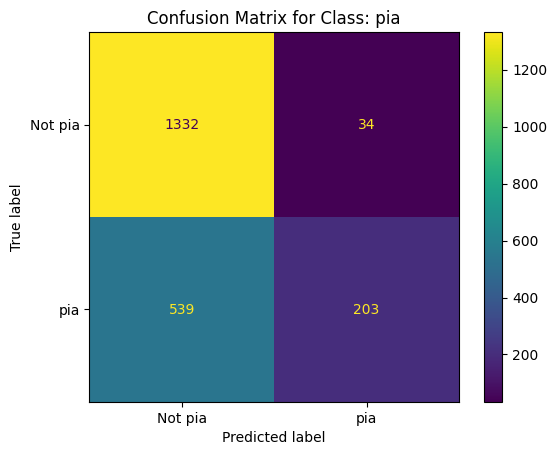

Class: sax
  Precision: 0.5393
  Recall:    0.7893
  F1 Score:  0.6407
  Confusion Matrix:
[[1671  176]
 [  55  206]]



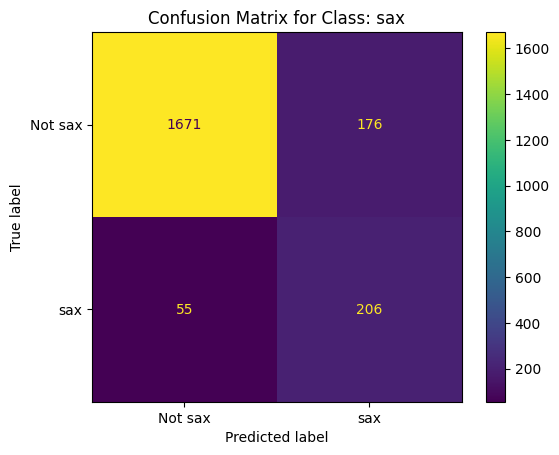

Class: tru
  Precision: 0.3706
  Recall:    0.3926
  F1 Score:  0.3813
  Confusion Matrix:
[[1883   90]
 [  82   53]]



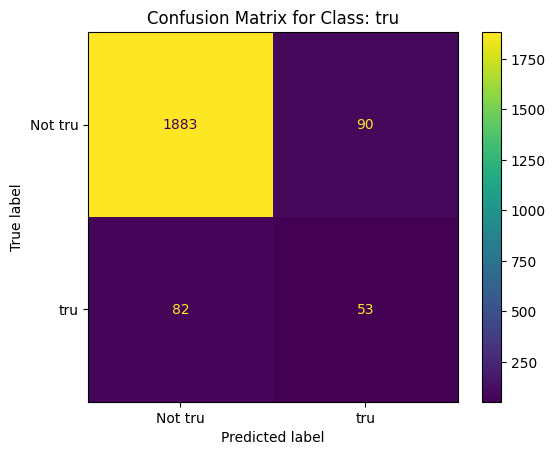

Class: vio
  Precision: 0.3899
  Recall:    0.4882
  F1 Score:  0.4336
  Confusion Matrix:
[[1884   97]
 [  65   62]]



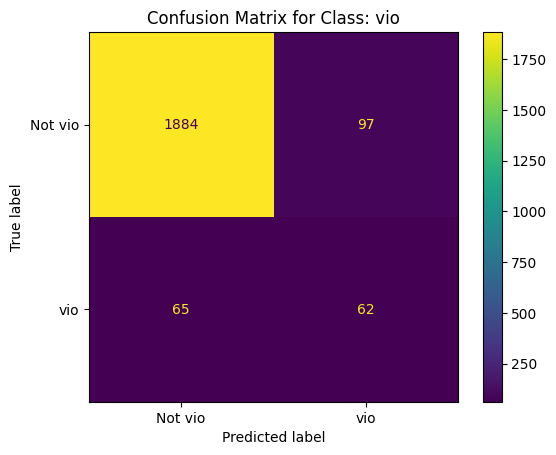

Class: voi
  Precision: 0.9092
  Recall:    0.9127
  F1 Score:  0.9109
  Confusion Matrix:
[[1246   72]
 [  69  721]]



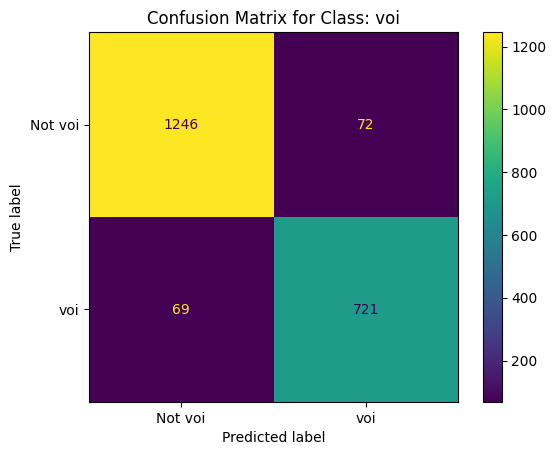

Exact Match Accuracy (Subset Accuracy): 0.2566
Hamming Accuracy: 0.8829


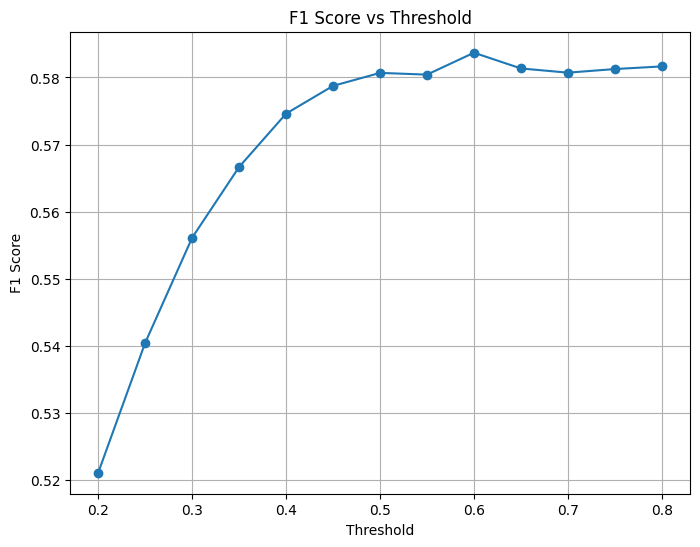

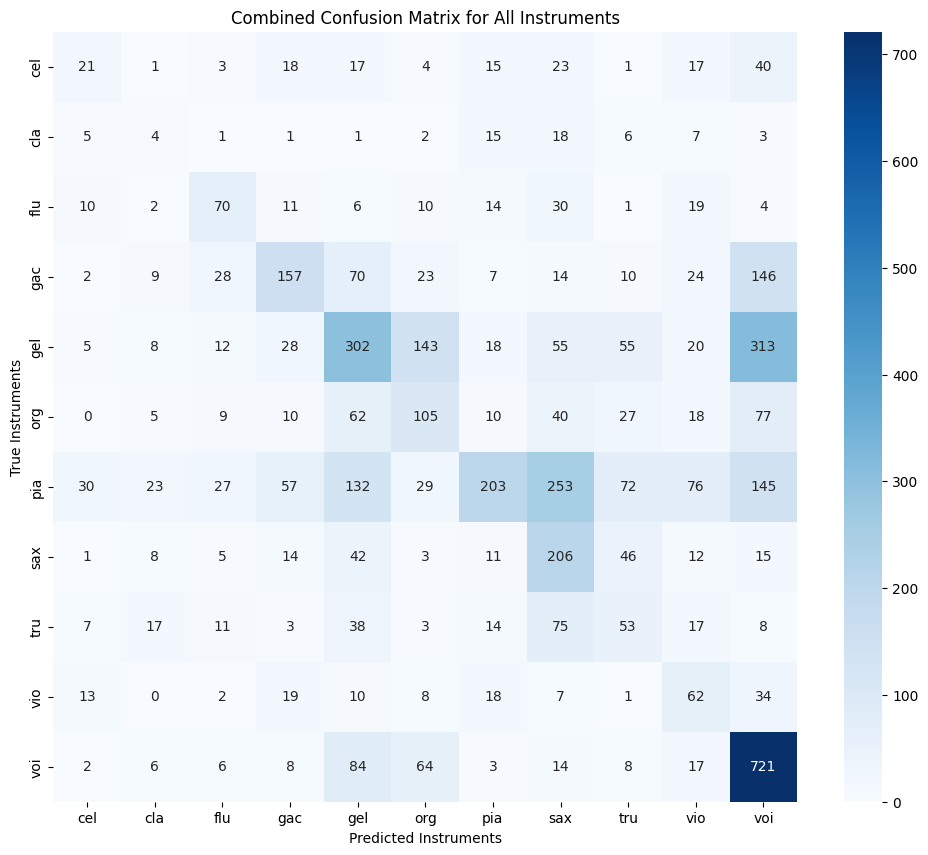

In [20]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.metrics import (f1_score, multilabel_confusion_matrix,
                             ConfusionMatrixDisplay, precision_recall_fscore_support,
                             accuracy_score, hamming_loss)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
model.to(device)

# Instantiate the test dataset and DataLoader
test_dataset = IRMASTestDataset(
    file_paths=test_file_paths,
    labels=test_labels,
    label_encoder=label_encoder,
    target_sr=22050,
    n_fft=1024,
    hop_length=512,
    n_mels=128,
    window_size=3.0,
    hop_size=1.5,
    transform=None
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Define thresholds
thresholds = np.linspace(0.2, 0.8, 13)
best_f1 = 0.0
best_threshold = 0.5
f1_scores = []

# Store true labels and predicted labels
all_true_labels = []
all_predicted_labels = {threshold: [] for threshold in thresholds}

# Testing loop
for segments, target, file_path in tqdm(test_loader, desc='Testing'):
    segments = segments.squeeze(0)
    target = target.to(device)
    num_segments = segments.size(0)
    segments = segments.to(device)

    # Collect outputs for all segments
    outputs = []
    with torch.no_grad():
        for i in range(num_segments):
            input_segment = segments[i].unsqueeze(0)
            logits = model(input_segment)
            sigmoid_output = torch.sigmoid(logits)
            outputs.append(sigmoid_output.cpu().numpy())

    outputs = np.vstack(outputs)

    # Aggregate predictions by averaging class-wise
    avg_outputs = np.mean(outputs, axis=0)

    # Normalize by dividing by the maximum value among classes
    if np.max(avg_outputs) > 0:
        normalized_outputs = avg_outputs / np.max(avg_outputs)
    else:
        normalized_outputs = avg_outputs

    # Store true labels
    true_labels = target.cpu().numpy()
    all_true_labels.append(true_labels)

    # Apply different thresholds and store predictions
    for threshold in thresholds:
        predicted_labels = (normalized_outputs >= threshold).astype(int)
        all_predicted_labels[threshold].append(predicted_labels)

all_true_labels = np.vstack(all_true_labels)

# Compute F1 scores for each threshold
for threshold in thresholds:
    preds = np.vstack(all_predicted_labels[threshold])
    f1 = f1_score(all_true_labels, preds, average='micro', zero_division=0)
    f1_scores.append(f1)
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_preds = preds

print(f"\nBest Threshold: {best_threshold:.2f}, Best F1 Score: {best_f1:.4f}")

# Compute confusion matrices for the best threshold
confusion_matrices = multilabel_confusion_matrix(all_true_labels, best_preds)

# Display confusion matrices and metrics for each class
class_labels = label_encoder.classes_

# Compute class-wise precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(
    all_true_labels,
    best_preds,
    average=None,
    zero_division=0
)

for idx, (cm, label) in enumerate(zip(confusion_matrices, class_labels)):
    print(f"Class: {label}")
    print(f"  Precision: {precision[idx]:.4f}")
    print(f"  Recall:    {recall[idx]:.4f}")
    print(f"  F1 Score:  {f1[idx]:.4f}")
    print(f"  Confusion Matrix:\n{cm}\n")

    # Optionally display confusion matrix as a plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Not {label}', label])
    disp.plot(values_format='d')
    plt.title(f'Confusion Matrix for Class: {label}')
    plt.show()

# Calculate Exact Match Accuracy (Subset Accuracy)
exact_match_accuracy = accuracy_score(all_true_labels, best_preds)
print(f"Exact Match Accuracy (Subset Accuracy): {exact_match_accuracy:.4f}")

# Calculate Hamming Loss and Hamming Accuracy
hamming_loss_value = hamming_loss(all_true_labels, best_preds)
hamming_accuracy = 1 - hamming_loss_value
print(f"Hamming Accuracy: {hamming_accuracy:.4f}")

# Plot F1 Score vs Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, marker='o')
plt.title('F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

# Compute the combined confusion matrix
num_classes = all_true_labels.shape[1]
combined_confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

for true_labels, predicted_labels in zip(all_true_labels, best_preds):
    true_indices = np.where(true_labels == 1)[0]
    pred_indices = np.where(predicted_labels == 1)[0]
    for i in true_indices:
        for j in pred_indices:
            combined_confusion_matrix[i][j] += 1

# Display the combined confusion matrix
confusion_df = pd.DataFrame(combined_confusion_matrix, index=class_labels, columns=class_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
plt.title('Combined Confusion Matrix for All Instruments')
plt.xlabel('Predicted Instruments')
plt.ylabel('True Instruments')
plt.show()